In [1]:
import pandas as pd
import geopandas as gpd

from sklearn.metrics import f1_score
import seaborn as sns
import pylab as plt

%matplotlib inline

# Load in target data

In [2]:
# load in target
target = pd.read_csv('../data/train.csv')
target['Occurrence Local Date Time'] = pd.to_datetime(target['Occurrence Local Date Time'])
target.head()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id,isAccident,isPedestrian
0,60558,2016-01-01 00:53:31,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.540896,-33.888275,S0B3CGQ,False,False
1,60559,2016-01-01 00:54:46,CAMERA,Accident,With A Fixed Object,Closed,18.930756,-34.140857,RYJYAPI,True,False
2,60560,2016-01-01 02:26:16,Law Enforcement,Accident,Multi Vehicle,Closed,18.553358,-33.959154,U3KP57C,True,False
3,60561,2016-01-01 02:56:26,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.677556,-33.895258,RY0TRQ8,False,False
4,60562,2016-01-01 03:40:48,CAMERA,Accident,Multi Vehicle,Closed,18.837132,-34.087051,8LOVJZ3,True,False


In [3]:
target['Occurrence Local Date Time'].min(), target['Occurrence Local Date Time'].max() 

(Timestamp('2016-01-01 00:53:31'), Timestamp('2018-12-31 23:45:00'))

Need to get data for model in these ranges

## Quick EDA about target

In [4]:
# About target
print('{:2.1f}% of events are Accidents'.format(target.isAccident.sum() / target.shape[0]*100))

8.8% of events are Accidents


In [5]:
# number of unique segments
target.road_segment_id.nunique()

544

In [6]:
# avg accident per road segment
(target.groupby('road_segment_id').isAccident.sum() / target.groupby('road_segment_id').isAccident.count()).mean()

0.16134182135133934

In [7]:
# number of road segments without accidents
(target.groupby('road_segment_id').isAccident.sum() == 0).sum() / target.road_segment_id.nunique()

0.13786764705882354

Text(0.5, 0, 'Number of Accidents per Segment')

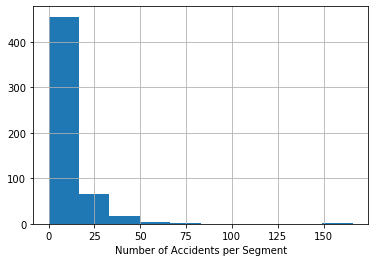

In [8]:
target.groupby('road_segment_id').isAccident.sum().hist()
plt.xlabel('Number of Accidents per Segment')

Text(0, 0.5, 'Number of Accidents')

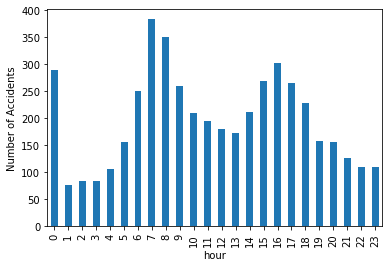

In [9]:
# time when accidents occur
per_hour = target.set_index('Occurrence Local Date Time').groupby(pd.Grouper(freq='H'))[['isAccident']].sum()
per_hour['hour'] = per_hour.index.hour
per_hour.groupby('hour').isAccident.sum().plot(kind='bar')
plt.ylabel('Number of Accidents')

Text(0, 0.5, 'Number of Accidents')

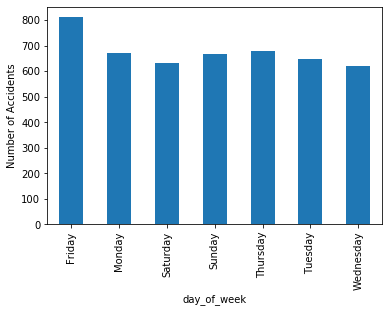

In [10]:
per_hour['day_of_week'] = per_hour.index.day_name()
per_hour.groupby('day_of_week').isAccident.sum().plot(kind='bar')
plt.ylabel('Number of Accidents')

# SANRAL data

In [17]:
sanral = pd.read_csv('../data/VDS_Vehicle Detection Sensor Data/2017/WC July 2017 Hourly.csv',sep=';',header=None)
sanral.head()

,0,1,2,3,4,5,6
0,WC,DS VDS 101 IB,2017-07-01 00:00:00.0000000,0,1,426,96.07
1,WC,DS VDS 101 IB,2017-07-01 00:00:00.0000000,0,2,4,96.07
2,WC,DS VDS 101 IB,2017-07-01 00:00:00.0000000,0,3,9,96.07
3,WC,DS VDS 101 OB,2017-07-01 00:00:00.0000000,0,1,751,96.66
4,WC,DS VDS 101 OB,2017-07-01 00:00:00.0000000,0,2,4,96.66


# Uber data

In [20]:
# load csv
uber_travel_time = pd.read_csv('../data/Travels times/cape_town-travel_zones-2016-1-All-HourlyAggregate.csv')
uber_travel_time.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,1,2,4,381.57,362.21,273.97,2.20
1,1,2,11,426.65,492.64,324.35,1.94
2,1,2,18,355.03,378.16,274.10,1.92
3,1,3,1,131.52,134.60,90.41,2.51
4,1,3,8,131.34,142.81,92.70,2.35


,TZ2015,MOVEMENT_ID,DISPLAY_NAME,geometry
0,101,1,Zone 101,"POLYGON Z ((18.42354 -33.91838 0.00000, 18.423..."
1,102,2,Zone 102,"POLYGON Z ((18.42662 -33.93065 0.00000, 18.426..."
2,103,3,Zone 103,"POLYGON Z ((18.41961 -33.92199 0.00000, 18.418..."
3,104,4,Zone 104,"POLYGON Z ((18.42354 -33.91838 0.00000, 18.423..."
4,105,5,Zone 105,"POLYGON Z ((18.43103 -33.92362 0.00000, 18.430..."


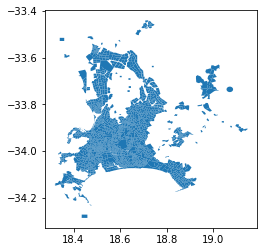

In [25]:
uber_shapefile = gpd.read_file('../data/cape_town_travel_zones.json')
uber_shapefile.geometry.plot()
uber_shapefile.head()

# Road data

,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,segment_id,geometry
0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,D1U6OOF,"LINESTRING (18.65262 -33.97724, 18.65264 -33.9..."
1,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,NG4X2MD,"LINESTRING (18.65347 -33.97309, 18.65347 -33.9..."
2,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,792705Z,"LINESTRING (18.65431 -33.96894, 18.65432 -33.9..."
3,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,IK67XHB,"LINESTRING (18.65515 -33.96480, 18.65517 -33.9..."
4,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,OWCF2MH,"LINESTRING (18.65600 -33.96065, 18.65602 -33.9..."


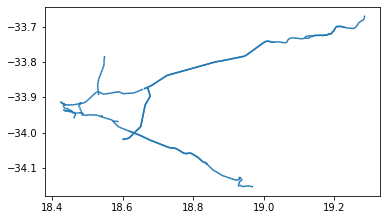

In [26]:
road_segments = gpd.read_file('../data/road_segments/road_segments.shp')
road_segments.geometry.plot()
road_segments.head()

In [27]:
road_segments.segment_id.nunique()

552

# Create a simple model

In [19]:
# what format should sample be in
sample_submission = pd.read_csv('../data/SampleSubmission.csv')
sample_submission.head()

,datetime x segment_id,prediction
0,2019-01-01 01:00:00 x S0B3CGQ,NaN
1,2019-01-01 01:00:00 x RYJYAPI,NaN
2,2019-01-01 01:00:00 x U3KP57C,NaN
3,2019-01-01 01:00:00 x RY0TRQ8,NaN
4,2019-01-01 01:00:00 x 8LOVJZ3,NaN


In [14]:
def name_index(row):
    return '{time} x {segment}'.format(time=row['Occurrence Local Date Time'],
                                                        segment=row['road_segment_id'])

In [20]:
# naive implementation
submission = target.set_index('Occurrence Local Date Time').groupby([pd.Grouper(freq='H'), 'road_segment_id']).isAccident.mean()
# change index
submission = submission.reset_index()
submission.index = submission.apply(name_index , axis=1)
# rename target
submission = submission.rename(columns={'isAccident':'prediction'})
submission.head()

,Occurrence Local Date Time,road_segment_id,prediction
2016-01-01 00:00:00 x RYJYAPI,2016-01-01 00:00:00,RYJYAPI,1.0
2016-01-01 00:00:00 x S0B3CGQ,2016-01-01 00:00:00,S0B3CGQ,0.0
2016-01-01 02:00:00 x RY0TRQ8,2016-01-01 02:00:00,RY0TRQ8,0.0
2016-01-01 02:00:00 x U3KP57C,2016-01-01 02:00:00,U3KP57C,1.0
2016-01-01 03:00:00 x 8LOVJZ3,2016-01-01 03:00:00,8LOVJZ3,1.0


In [ ]:
# do mean  
submission['prediction'] = 0

In [22]:
sample_submission['prediction'] = 0
sample_submission.to_csv('../data/predictions/1.0-zeros.csv', index=False)